In [8]:
import os
os.chdir("d:/python_projects/london-city-bikes")

import numpy as np
import torch
import matplotlib.pyplot as plt
import mlflow

In [9]:
from src.dataset import get_dataloaders

from src.model import LSTMModel, LinearWeightedMSELoss
from src.train import train_model, DEVICE
from src.metrics import evaluate_predictions
from src.predict import predict
from src.mlflow_logging import log_trained_model, log_true_and_predictions_values
from src.mlflow_logging import log_model_architecture, log_train_parameters

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
PRED_LENGTH = 48
MODELS_BASENAME = "pytorch_model"
print(f"Using device: {DEVICE}")

Using device: cuda


In [11]:
train_dataloaders, val_dataloaders, scalers = get_dataloaders()

# Training

Custom errors implementation

In [24]:
# Hyperparameters
INPUT_SIZE = 12
FUTURE_FEATURE_SIZE = 10
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2 * PRED_LENGTH
NUM_LAYERS = 1
NUM_EPOCHS = 3
DROPOUT = 0
LEARNING_RATE = 0.0001

# Train separate model for each cluster

In [25]:
list(train_dataloaders.keys())[:1]

[27]

Training for Cluster 27
Epoch [1/3] - Train Loss: 0.0097, Train MAE: 0.0603, Val Loss: 0.0046, Val MAE: 0.0433
Epoch [2/3] - Train Loss: 0.0056, Train MAE: 0.0457, Val Loss: 0.0038, Val MAE: 0.0382
Epoch [3/3] - Train Loss: 0.0051, Train MAE: 0.0434, Val Loss: 0.0037, Val MAE: 0.0382


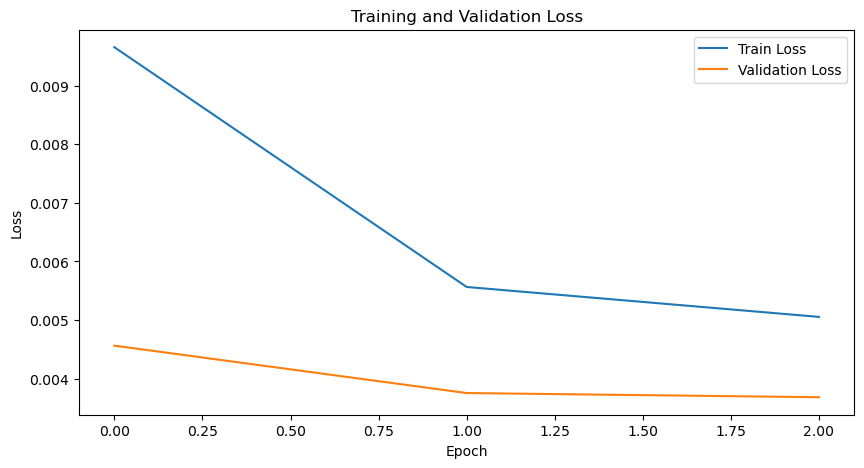

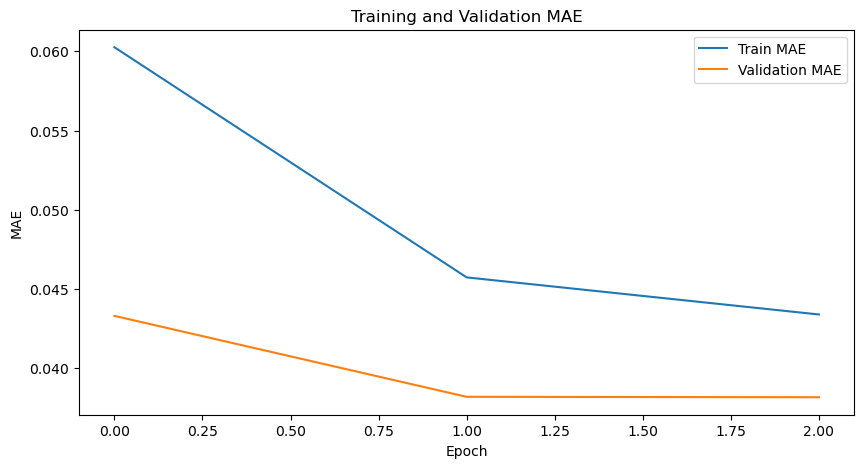

2025/04/12 15:21:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/12 15:21:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/12 15:21:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Prediction for cluster: 27
Overall Metrics:
  MAE: 3.1181
  RMSE: 4.6301
  R2: 0.6714
  sMAPE: 72.2361%


In [26]:
#for cluster in train_dataloaders.keys():
for cluster in list(train_dataloaders.keys())[:1]:
    model = LSTMModel(
        input_size=INPUT_SIZE, 
        hidden_size=HIDDEN_SIZE, 
        future_feature_size=FUTURE_FEATURE_SIZE,
        output_size=OUTPUT_SIZE, 
        pred_length=PRED_LENGTH,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ).to(DEVICE)

    criterion = LinearWeightedMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print(f'Training for Cluster {cluster}')
    train_dataloader = train_dataloaders[cluster]
    val_dataloader = val_dataloaders[cluster]
    
    mlflow.start_run()
    log_model_architecture(model)
    log_train_parameters(NUM_EPOCHS, optimizer, criterion, train_dataloader.batch_size, cluster)
    
    model = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=NUM_EPOCHS)
    torch.save(model, f'./data/models/model_{cluster}.pth')
    log_trained_model(model, MODELS_BASENAME + f"_{cluster}")

    all_preds = {}
    all_true = {}

    print(f"Prediction for cluster: {cluster}")
    val_dataloader = val_dataloaders[cluster]
    scaler = scalers[cluster]
    all_preds[cluster], all_true[cluster], metadata = predict(model, val_dataloader, scaler)
    metrics = evaluate_predictions(all_true[cluster], all_preds[cluster], metadata)

    print(f"Overall Metrics:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}")
    print(f"  sMAPE: {metrics['sMAPE']:.4f}%")

    true_values_filename = f"./data/results/true_values_{cluster}.npy"
    predictions_filename = f"./data/results/predictions_{cluster}.npy"
    np.save(true_values_filename, all_preds[cluster])
    np.save(predictions_filename, all_true[cluster])    
    log_true_and_predictions_values(true_values_filename, predictions_filename)
    mlflow.end_run()


In [29]:
original_scale_true = all_true[27]
original_scale_predictions = all_preds[27]

In [30]:
# Extract true and predicted values for Starts and Ends
true_starts = original_scale_true[:, :, 0]  # Shape: (batch_size, pred_length)
true_ends = original_scale_true[:, :, 1]    # Shape: (batch_size, pred_length)
pred_starts = original_scale_predictions[:, :, 0]  # Shape: (batch_size, pred_length)
pred_ends = original_scale_predictions[:, :, 1]    # Shape: (batch_size, pred_length)

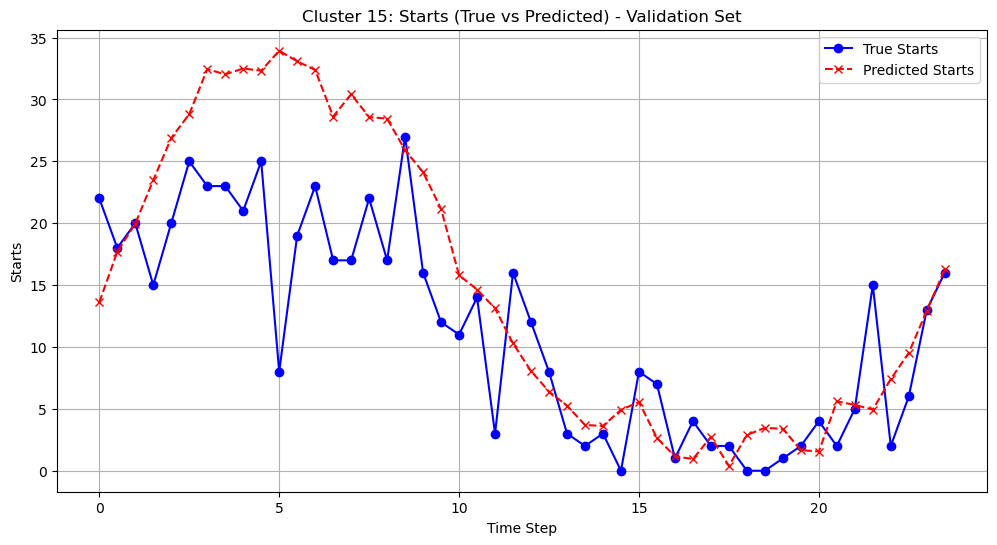

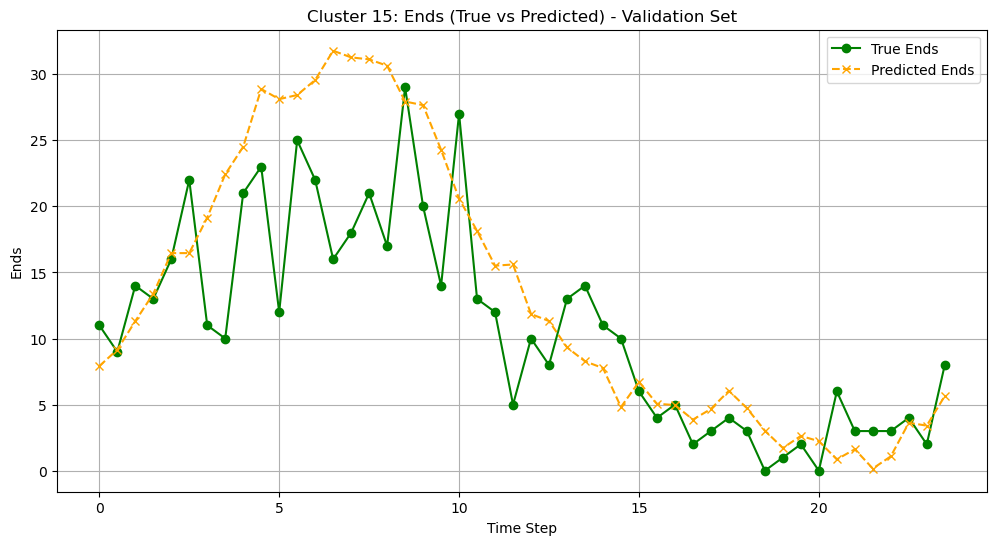

In [36]:
index = 48 * 5

# Plot Starts for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_starts[index], label="True Starts", color="blue", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_starts[index], label="Predicted Starts", color="red", linestyle="--", marker="x")
plt.title(f"Cluster {cluster}: Starts (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Starts")
plt.legend()
plt.grid(True)
plt.show()

# Plot Ends for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_ends[index], label="True Ends", color="green", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_ends[index], label="Predicted Ends", color="orange", linestyle="--", marker="x")
plt.title(f"Cluster {cluster}: Ends (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Ends")
plt.legend()
plt.grid(True)
plt.show()